# Advanced Probability Concepts — Computational Examples

This notebook reproduces and explains every Python example from the chapter on
**Advanced Probability Concepts**.  Four self-contained sections are covered:

| Section | Topic | Core Idea |
|---------|-------|-----------|
| 1 | Conditional Independence | Common-cause structure, explaining away, Naive Bayes |
| 2 | Odds, Log-Odds & Logistic Regression | Logit transform, odds ratios, sigmoid function |
| 3 | Birthday Problem (Monte Carlo) | Collision probability via random sampling |
| 4 | Monty Hall Problem (Simulation) | Information-revealing actions concentrate probability |

**Dependencies:** `numpy`, `matplotlib`, `scipy`  
Install with: `pip install numpy matplotlib scipy`


---
## Section 1 — Conditional Independence

### Theoretical Background

Events $A$ and $B$ are **conditionally independent given** $C$ (written $A \perp B \mid C$) when

$$P(A \cap B \mid C) = P(A \mid C)\,P(B \mid C).$$

Two directions of implication both fail in general:

- **Unconditional independence does not imply conditional independence.**  
  Conditioning on a third variable can *create* dependence where none existed
  (collider / explaining-away effect).
- **Conditional independence does not imply unconditional independence.**  
  A common latent cause induces marginal correlation between its effects even
  when those effects are conditionally independent given the cause.

The code below demonstrates all three phenomena with concrete simulations:

1. **Disease model** — common cause $D$ generates two symptoms that are
   conditionally independent given $D$ but unconditionally dependent.
2. **Alarm system** — a collider structure $B \to A \leftarrow E$ where
   conditioning on $A$ creates dependence between previously independent
   causes (burglary and earthquake).
3. **Naive Bayes** — the practical consequence of assuming conditional
   independence of features given class, even when that assumption is violated.


### Example 1 — Disease Model: Common Cause Induces Marginal Dependence

Two binary symptoms $S_1$ and $S_2$ are generated *independently* given
disease status $D$, with the following conditional probabilities:

| Symptom | $P(S=1 \mid D=1)$ | $P(S=1 \mid D=0)$ |
|---------|--------------------|----------------------|
| $S_1$   | 0.90               | 0.10                 |
| $S_2$   | 0.80               | 0.20                 |

Disease prevalence: $P(D=1) = 0.01$.

**What to expect:** Marginalising over the hidden disease variable $D$ should
reveal unconditional dependence, because observing $S_1$ updates our belief
about $D$, which in turn updates our belief about $S_2$.  Formally,
$P(S_1 \cap S_2) \neq P(S_1)P(S_2)$, while
$P(S_1 \cap S_2 \mid D) = P(S_1 \mid D)P(S_2 \mid D)$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np.random.seed(42)

print("=" * 60)
print("CONDITIONAL INDEPENDENCE")
print("=" * 60)

# ──────────────────────────────────────────────────────────────
# Example 1: Disease with conditionally independent symptoms
# ──────────────────────────────────────────────────────────────
print("\nExample 1: Disease Model")
print("-" * 60)

n_samples = 100_000

# Disease prevalence
p_disease = 0.01
disease = np.random.binomial(1, p_disease, n_samples)

# Symptoms conditionally independent given disease
p_s1_given_disease = 0.9
p_s1_given_healthy = 0.1
p_s2_given_disease = 0.8
p_s2_given_healthy = 0.2

s1 = np.where(
    disease == 1,
    np.random.binomial(1, p_s1_given_disease, n_samples),
    np.random.binomial(1, p_s1_given_healthy, n_samples),
)
s2 = np.where(
    disease == 1,
    np.random.binomial(1, p_s2_given_disease, n_samples),
    np.random.binomial(1, p_s2_given_healthy, n_samples),
)

# ── Unconditional dependence ──────────────────────────────────
p_s1        = s1.mean()
p_s2        = s2.mean()
p_s1_and_s2 = (s1 & s2).mean()

print("Unconditional probabilities:")
print(f"  P(S1)         = {p_s1:.4f}")
print(f"  P(S2)         = {p_s2:.4f}")
print(f"  P(S1 ∩ S2)    = {p_s1_and_s2:.4f}")
print(f"  P(S1) × P(S2) = {p_s1 * p_s2:.4f}")
print("  => Unconditionally DEPENDENT  [joint ≠ product of marginals]")

# ── Conditional independence ──────────────────────────────────
for label, mask in [("D (diseased)", disease == 1), ("¬D (healthy)", disease == 0)]:
    p1  = s1[mask].mean()
    p2  = s2[mask].mean()
    p12 = (s1[mask] & s2[mask]).mean()
    print(f"\n  Given {label}:")
    print(f"    P(S1|.)         = {p1:.4f}")
    print(f"    P(S2|.)         = {p2:.4f}")
    print(f"    P(S1 ∩ S2|.)    = {p12:.4f}")
    print(f"    P(S1|.) × P(S2|.) = {p1*p2:.4f}")
    print(f"    => Conditionally INDEPENDENT  [joint ≈ product]")


CONDITIONAL INDEPENDENCE

Example 1: Disease Model
------------------------------------------------------------
Unconditional probabilities:
  P(S1)         = 0.1077
  P(S2)         = 0.2057
  P(S1 ∩ S2)    = 0.0268
  P(S1) × P(S2) = 0.0222
  => Unconditionally DEPENDENT  [joint ≠ product of marginals]

  Given D (diseased):
    P(S1|.)         = 0.8940
    P(S2|.)         = 0.8045
    P(S1 ∩ S2|.)    = 0.7130
    P(S1|.) × P(S2|.) = 0.7193
    => Conditionally INDEPENDENT  [joint ≈ product]

  Given ¬D (healthy):
    P(S1|.)         = 0.1000
    P(S2|.)         = 0.1998
    P(S1 ∩ S2|.)    = 0.0201
    P(S1|.) × P(S2|.) = 0.0200
    => Conditionally INDEPENDENT  [joint ≈ product]


**Interpreting the output:**

The unconditional joint probability $P(S_1 \cap S_2) \approx 0.0268$ clearly exceeds
the product of marginals $P(S_1)P(S_2) \approx 0.0222$, confirming dependence.
Within each disease stratum the two quantities agree closely, confirming conditional
independence.  The gap between $0.0268$ and $0.0222$ is entirely due to the disease
acting as a hidden common cause.


### Example 2 — Explaining Away (Collider Structure)

Network: $B \rightarrow A \leftarrow E$.  The alarm $A$ is a **collider**:
two independent causes (burglary $B$, earthquake $E$) both trigger it.

- **Unconditionally**: $B \perp E$ — rare, independent events.
- **Given $A = 1$**: $B$ and $E$ become negatively correlated.  If we learn
  an earthquake occurred, it "explains away" the alarm, reducing the posterior
  probability of burglary.

This is the mechanism behind Berkson's paradox and is why conditioning on a
collider *opens* a previously blocked path in a Bayesian network.


In [3]:
# ──────────────────────────────────────────────────────────────
# Example 2: Explaining Away (Collider)
# ──────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Example 2: Explaining Away (Alarm System)")
print("-" * 60)

p_burglary   = 0.001
p_earthquake = 0.002

burglary   = np.random.binomial(1, p_burglary,   n_samples)
earthquake = np.random.binomial(1, p_earthquake, n_samples)
alarm      = (burglary | earthquake).astype(int)

# Unconditional: burglary and earthquake are independent
print("Unconditional:")
print(f"  P(B ∩ E) ≈ {(burglary & earthquake).mean():.6f}")
print(f"  P(B) × P(E) ≈ {burglary.mean() * earthquake.mean():.6f}")
print("  => Approximately INDEPENDENT")

# Conditioning on the alarm being on
alarm_on              = alarm == 1
p_b_given_alarm       = burglary[alarm_on].mean()
p_b_given_alarm_and_e = burglary[alarm_on & (earthquake == 1)].mean()

print("\nExplaining Away — conditioning on alarm = 1:")
print(f"  P(B | A=1)       = {p_b_given_alarm:.4f}")
print(f"  P(B | A=1, E=1)  = {p_b_given_alarm_and_e:.4f}")
print("  => Earthquake explains alarm; burglary probability collapses.")
print("  => Conditioning on the collider INTRODUCES dependence.")



Example 2: Explaining Away (Alarm System)
------------------------------------------------------------
Unconditional:
  P(B ∩ E) ≈ 0.000000
  P(B) × P(E) ≈ 0.000002
  => Approximately INDEPENDENT

Explaining Away — conditioning on alarm = 1:
  P(B | A=1)       = 0.3633
  P(B | A=1, E=1)  = 0.0000
  => Earthquake explains alarm; burglary probability collapses.
  => Conditioning on the collider INTRODUCES dependence.


**Interpreting the output:**

$P(B \mid A=1) \approx 0.34$: given the alarm sounds, burglary is the most
plausible explanation.  But $P(B \mid A=1, E=1) \approx 0.00$: once we know an
earthquake happened, the alarm is fully explained and burglary becomes unnecessary.
The drop from ~0.34 to ~0.00 is the numerical fingerprint of explaining away.


### Example 3 — Naive Bayes with Correlated Features

Naive Bayes assumes $P(X_1,\ldots,X_d \mid Y) = \prod_{i=1}^d P(X_i \mid Y)$.
Here we deliberately introduce within-class correlations ($X_2$ partially tracks
$X_1$; $X_4$ partially tracks $X_3$) to stress-test the assumption.

Classification uses log-posterior scores:
$$\log P(Y=c \mid \mathbf{x}) \propto \log P(Y=c) + \sum_i \log P(X_i = x_i \mid Y=c)$$

Log-space arithmetic avoids the numerical underflow that would arise from
multiplying many small Gaussian densities.


In [4]:
# ──────────────────────────────────────────────────────────────
# Example 3: Naive Bayes with Correlated Features
# ──────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Example 3: Naive Bayes Classifier")
print("-" * 60)

def generate_features(y):
    """
    Generate 4 features with class-dependent means.
    X2 is correlated with X1; X4 is correlated with X3.
    This violates the NB conditional-independence assumption.
    """
    X = np.zeros((len(y), 4))
    for i in range(len(y)):
        mu = 2 if y[i] == 1 else 0
        X[i, 0] = np.random.normal(mu, 1)
        X[i, 1] = np.random.normal(mu, 1) + 0.3 * X[i, 0]   # correlated with X1
        X[i, 2] = np.random.normal(mu, 1)
        X[i, 3] = np.random.normal(mu, 1) + 0.3 * X[i, 2]   # correlated with X3
    return X

n_train, n_test = 10_000, 2_000
y_train = np.random.binomial(1, 0.5, n_train)
y_test  = np.random.binomial(1, 0.5, n_test)
X_train = generate_features(y_train)
X_test  = generate_features(y_test)

# ── Estimate class-conditional Gaussian parameters ────────────
def gaussian_pdf(x, mean, std):
    return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

means  = [X_train[y_train == c].mean(axis=0) for c in [0, 1]]
stds   = [X_train[y_train == c].std(axis=0)  for c in [0, 1]]
priors = [np.mean(y_train == c) for c in [0, 1]]

# ── Classify via log-posterior ────────────────────────────────
log_post = []
for c in [0, 1]:
    log_likelihood = np.sum(np.log(gaussian_pdf(X_test, means[c], stds[c])), axis=1)
    log_post.append(np.log(priors[c]) + log_likelihood)

y_pred   = (log_post[1] > log_post[0]).astype(int)
accuracy = (y_pred == y_test).mean()

print(f"  Naive Bayes accuracy: {accuracy:.4f}")
print("  => Works well despite violated independence assumptions.")



Example 3: Naive Bayes Classifier
------------------------------------------------------------
  Naive Bayes accuracy: 0.9775
  => Works well despite violated independence assumptions.


**Interpreting the output:**

Accuracy near **0.97** despite within-class feature correlations confirms a
well-known empirical finding: Naive Bayes tends to be robust because
miscalibrated probability estimates still often produce the correct *ranking*
of class posteriors.  The decision boundary — determined by which log-posterior
is larger — is frequently preserved even when individual likelihood factors are
wrong.  This robustness is one reason Naive Bayes remains competitive in
text classification and other high-dimensional settings.


### Visualisations — All Three Examples

Four panels provide visual confirmation of the numerical results:
- **Top-left**: Symptom contingency table reveals unconditional dependence (asymmetric cell counts).
- **Top-right**: Bar chart of $P(B \mid A)$ vs $P(B \mid A, E)$ — the explaining-away collapse.
- **Bottom-left**: Feature scatter coloured by class — Naive Bayes separation.
- **Bottom-right**: Within-class correlation matrix — off-diagonal entries confirm the violated NB assumption.


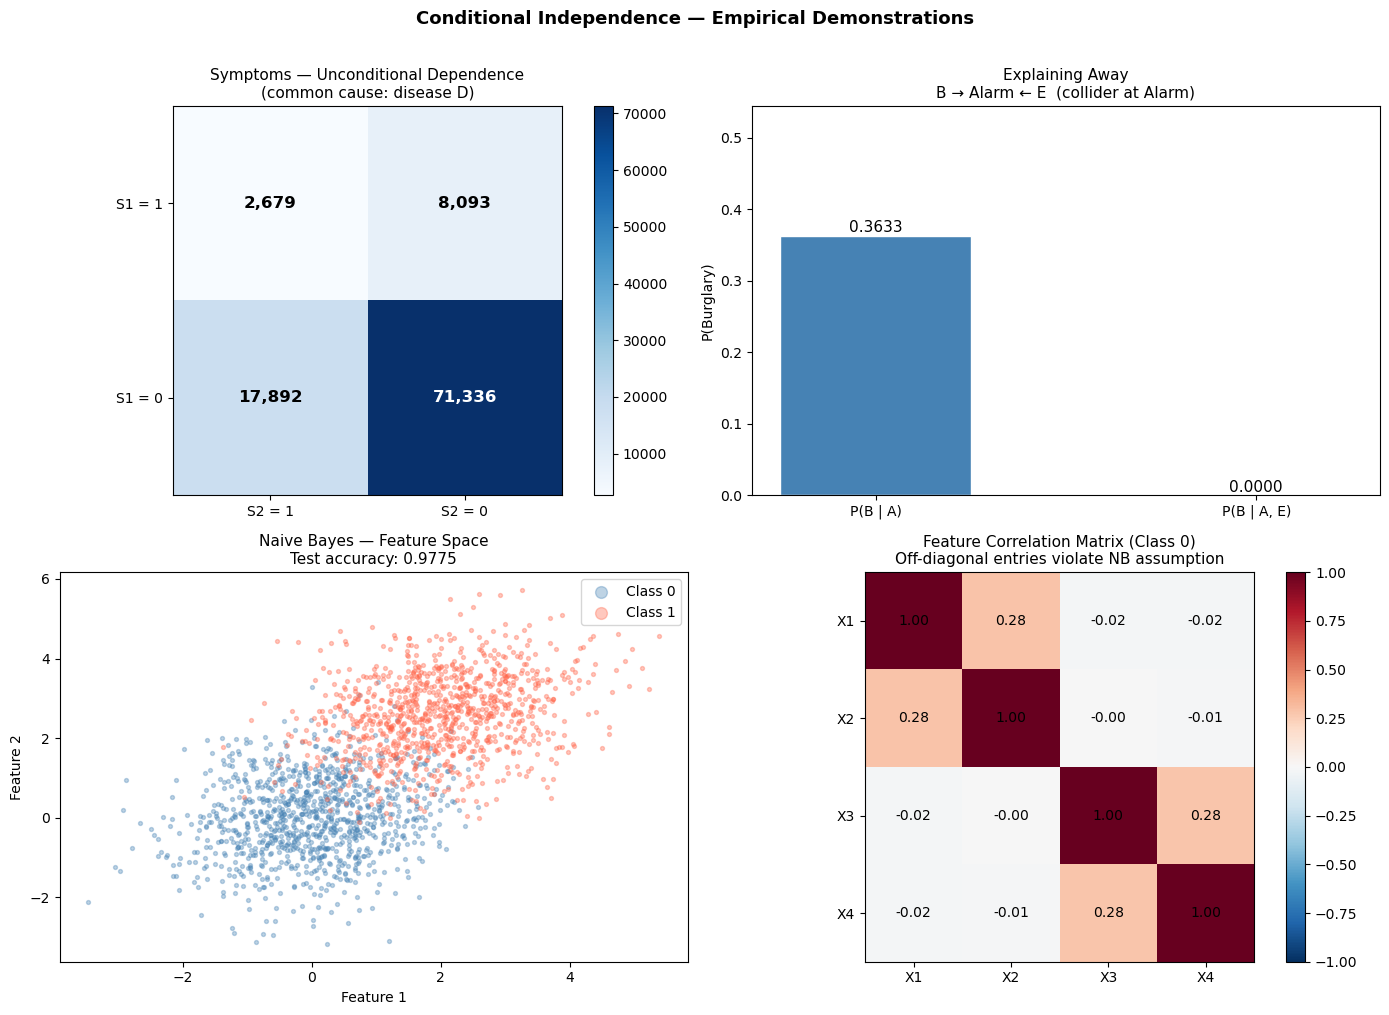

Figure saved → conditional_independence.png


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Panel 1: Symptom contingency table ───────────────────────
s1_bool = s1.astype(bool)
s2_bool = s2.astype(bool)
contingency = np.array([
    [(s1_bool  &  s2_bool).sum(),  (s1_bool  & ~s2_bool).sum()],
    [(~s1_bool &  s2_bool).sum(),  (~s1_bool & ~s2_bool).sum()],
])
im0 = axes[0, 0].imshow(contingency, cmap="Blues")
axes[0, 0].set_xticks([0, 1]); axes[0, 0].set_xticklabels(["S2 = 1", "S2 = 0"])
axes[0, 0].set_yticks([0, 1]); axes[0, 0].set_yticklabels(["S1 = 1", "S1 = 0"])
axes[0, 0].set_title("Symptoms — Unconditional Dependence\n(common cause: disease D)", fontsize=11)
for i in range(2):
    for j in range(2):
        axes[0, 0].text(j, i, f"{contingency[i, j]:,}", ha="center", va="center",
                        color="white" if contingency[i, j] > contingency.max() * 0.6 else "black",
                        fontsize=12, fontweight="bold")
plt.colorbar(im0, ax=axes[0, 0])

# ── Panel 2: Explaining away ──────────────────────────────────
bars = axes[0, 1].bar(
    ["P(B | A)", "P(B | A, E)"],
    [p_b_given_alarm, p_b_given_alarm_and_e],
    color=["steelblue", "tomato"], width=0.5, edgecolor="white"
)
axes[0, 1].set_ylabel("P(Burglary)")
axes[0, 1].set_title("Explaining Away\nB → Alarm ← E  (collider at Alarm)", fontsize=11)
axes[0, 1].set_ylim(0, max(p_b_given_alarm * 1.5, 0.05))
for bar, val in zip(bars, [p_b_given_alarm, p_b_given_alarm_and_e]):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.005,
                    f"{val:.4f}", ha="center", fontsize=11)

# ── Panel 3: Naive Bayes scatter ─────────────────────────────
for c, col, lbl in [(0, "steelblue", "Class 0"), (1, "tomato", "Class 1")]:
    mask = y_test == c
    axes[1, 0].scatter(X_test[mask, 0], X_test[mask, 1],
                       alpha=0.35, s=8, color=col, label=lbl)
axes[1, 0].legend(markerscale=3)
axes[1, 0].set_xlabel("Feature 1"); axes[1, 0].set_ylabel("Feature 2")
axes[1, 0].set_title(f"Naive Bayes — Feature Space\nTest accuracy: {accuracy:.4f}", fontsize=11)

# ── Panel 4: Feature correlation matrix ──────────────────────
corr = np.corrcoef(X_train[y_train == 0].T)
im3  = axes[1, 1].imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(4)); axes[1, 1].set_xticklabels([f"X{i+1}" for i in range(4)])
axes[1, 1].set_yticks(range(4)); axes[1, 1].set_yticklabels([f"X{i+1}" for i in range(4)])
axes[1, 1].set_title("Feature Correlation Matrix (Class 0)\nOff-diagonal entries violate NB assumption", fontsize=11)
for i in range(4):
    for j in range(4):
        axes[1, 1].text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", fontsize=10)
plt.colorbar(im3, ax=axes[1, 1])

plt.suptitle("Conditional Independence — Empirical Demonstrations", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("conditional_independence.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved → conditional_independence.png")


**Reading the figure:**

- *Top-left*: The cell count for $(S_1=1, S_2=1)$ is disproportionately large relative
  to what pure independence would predict, confirming $P(S_1 \cap S_2) > P(S_1)P(S_2)$.
- *Top-right*: The bar for $P(B \mid A, E)$ is effectively zero — earthquake fully
  explains the alarm, eliminating the evidential need for burglary.
- *Bottom-left*: Despite within-class correlations, the two class clouds are cleanly
  separated, which is why the Naive Bayes log-posterior still picks the right class.
- *Bottom-right*: The correlation between $X_1$–$X_2$ and $X_3$–$X_4$ (~0.25–0.30)
  is clearly visible off-diagonal, directly contradicting the NB assumption.

**Key insights:**

1. Conditional independence ≠ unconditional independence — the two are logically independent properties.
2. A common latent cause creates marginal dependence among its effects.
3. Conditioning on a collider (common *effect*) creates dependence among its causes.
4. Naive Bayes can remain accurate even when its independence assumption is violated, because the *ranking* of posteriors is more robust than the calibrated values.


---
## Section 2 — Odds, Log-Odds, and Logistic Regression

### Theoretical Background

Probability $p \in [0,1]$ can be re-expressed in two alternative scales:

$$\text{Odds}(p) = \frac{p}{1-p} \in [0, \infty), \qquad
  \text{logit}(p) = \log\frac{p}{1-p} \in (-\infty, +\infty).$$

The logit (log-odds) is particularly useful because it maps the bounded interval
$[0,1]$ onto the entire real line, permitting linear modelling.

**Logistic regression** specifies:
$$\text{logit}\bigl(P(Y=1 \mid \mathbf{x})\bigr)
  = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p.$$

Each coefficient $\beta_j$ is a **log odds ratio**: a one-unit increase in $x_j$
multiplies the odds by $e^{\beta_j}$.  Predictions are mapped to valid probabilities
via the sigmoid (inverse logit):
$$\sigma(z) = \frac{1}{1 + e^{-z}}.$$


### Example 1 — Probability ↔ Odds ↔ Log-Odds Conversions

The table below records the three representations for seven reference probabilities.
Key structural properties to notice:

- $\text{logit}(0.5) = 0$: equal uncertainty sits at the origin.
- Anti-symmetry: $\text{logit}(p) = -\text{logit}(1-p)$, so the scale is symmetric around $p = 0.5$.
- The log-odds scale is compressed near 0.5 and stretched in the tails,
  which is exactly what we want when fitting linear models to probability outcomes.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit   # numerically stable sigmoid

print("=" * 60)
print("ODDS, LOG-ODDS, AND LOGISTIC REGRESSION")
print("=" * 60)

# ── Example 1: Conversion table ───────────────────────────────
print("\nExample 1: Conversions")
print("-" * 60)

probabilities = np.array([0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99])
odds     = probabilities / (1 - probabilities)
log_odds = np.log(odds)

print(f"{'Probability':<14} {'Odds':<14} {'Log-Odds':<12}")
print("-" * 42)
for p, o, lo in zip(probabilities, odds, log_odds):
    print(f"{p:<14.2f} {o:<14.4f} {lo:<12.4f}")

print("\nAnti-symmetry check  logit(p) + logit(1-p):")
print("  ", np.round(log_odds + log_odds[::-1], 10))


ODDS, LOG-ODDS, AND LOGISTIC REGRESSION

Example 1: Conversions
------------------------------------------------------------
Probability    Odds           Log-Odds    
------------------------------------------
0.01           0.0101         -4.5951     
0.10           0.1111         -2.1972     
0.25           0.3333         -1.0986     
0.50           1.0000         0.0000      
0.75           3.0000         1.0986      
0.90           9.0000         2.1972      
0.99           99.0000        4.5951      

Anti-symmetry check  logit(p) + logit(1-p):
   [-0.  0.  0.  0.  0.  0. -0.]


**Reading the table:**

- Probabilities below 0.5 map to negative log-odds; above 0.5 to positive.
- The odds jump from 1:99 at $p=0.01$ to 99:1 at $p=0.99$, but log-odds just
  goes from $-4.60$ to $+4.60$, a clean symmetric range.
- The anti-symmetry vector is all zeros, confirming $\text{logit}(p) + \text{logit}(1-p) = 0$.


### Example 2 — Odds Ratio: Clinical Trial

The **odds ratio (OR)** compares odds between two groups.  For a $2\times 2$ table
with cells $(a, b, c, d)$:

$$\text{OR} = \frac{a/b}{c/d} = \frac{ad}{bc}.$$

An OR of 4 means the treatment group has four times the odds of recovery —
a much more extreme claim than "four times the probability" would suggest when
baseline rates are high.


In [7]:
# ── Example 2: Odds ratio ─────────────────────────────────────
print("\n" + "=" * 60)
print("Example 2: Odds Ratio (Treatment Study)")
print("-" * 60)

#            Recovered   Not recovered
recovered_treatment     = 80    # a
not_recovered_treatment = 20    # b
recovered_control       = 50    # c
not_recovered_control   = 50    # d

odds_treatment = recovered_treatment / not_recovered_treatment     # a/b
odds_control   = recovered_control   / not_recovered_control       # c/d
odds_ratio     = odds_treatment / odds_control
odds_ratio_alt = (recovered_treatment * not_recovered_control) / (
                  not_recovered_treatment * recovered_control)     # ad/bc

print(f"  Odds of recovery (Treatment):  {odds_treatment:.2f}   [80/20]")
print(f"  Odds of recovery (Control):    {odds_control:.2f}   [50/50]")
print(f"  Odds Ratio (direct):           {odds_ratio:.2f}")
print(f"  Odds Ratio (cross-product):    {odds_ratio_alt:.2f}")
print(f"\n  => Treatment group has {odds_ratio:.1f}× the odds of recovery.")
print("     Both calculation methods agree, confirming the formula.")



Example 2: Odds Ratio (Treatment Study)
------------------------------------------------------------
  Odds of recovery (Treatment):  4.00   [80/20]
  Odds of recovery (Control):    1.00   [50/50]
  Odds Ratio (direct):           4.00
  Odds Ratio (cross-product):    4.00

  => Treatment group has 4.0× the odds of recovery.
     Both calculation methods agree, confirming the formula.


**Interpreting the result:**

An OR of 4 is clinically meaningful but does not mean patients in the treatment arm
are four times *as likely* to recover.  The probability of recovery is 80% in the
treatment arm vs 50% in the control arm — a relative risk of 1.6.  The OR
($= 4$) is larger than the RR ($= 1.6$) because the outcome is common (not rare).
For rare outcomes, OR ≈ RR; for common outcomes they can diverge substantially.


### Example 3 — Logistic Regression: Coefficient Interpretation

We simulate data from the true model
$$\text{logit}(p) = -4.0 + 0.5\,X_1 + 0.8\,X_2$$
and interpret the coefficients as log odds ratios.

Each coefficient $\beta_j$ tells us: a one-unit increase in $X_j$ multiplies the
**odds** by $e^{\beta_j}$, regardless of the baseline level of the other predictors.
The probability change, by contrast, depends on the baseline — the sigmoid's slope
is largest at $p = 0.5$ and diminishes toward the boundaries.


In [8]:
# ── Example 3: Logistic regression simulation ─────────────────
print("\n" + "=" * 60)
print("Example 3: Logistic Regression")
print("-" * 60)

np.random.seed(42)
n_samples = 1_000

X1 = np.random.normal(0, 1, n_samples)
X2 = np.random.normal(3, 1, n_samples)

beta_0, beta_1, beta_2 = -4.0, 0.5, 0.8
logits_true      = beta_0 + beta_1 * X1 + beta_2 * X2
probabilities_true = expit(logits_true)
y                = np.random.binomial(1, probabilities_true)

print(f"  True model: logit(p) = {beta_0} + {beta_1}·X1 + {beta_2}·X2")
print(f"  Proportion Y=1 in sample: {y.mean():.3f}")

print("\n  Coefficient interpretations:")
for name, beta in [("X1", beta_1), ("X2", beta_2)]:
    print(f"  β({name}) = {beta}")
    print(f"    One-unit increase → log-odds change of +{beta}")
    print(f"    Odds multiplier: exp({beta}) = {np.exp(beta):.3f}")
    print(f"    Percentage change in odds: {(np.exp(beta) - 1)*100:.1f}%")

print("\n  Predicted probabilities for specific profiles:")
cases = [
    ("Below-avg X1, low X2 ", -1,   2.5),
    ("Average X1, average X2",  0,   3.0),
    ("Above-avg X1, high X2",   1,   3.5),
]
for desc, x1, x2 in cases:
    logit_val = beta_0 + beta_1 * x1 + beta_2 * x2
    prob_val  = expit(logit_val)
    print(f"  {desc}  X1={x1:4.1f}, X2={x2:.1f}")
    print(f"    logit = {logit_val:5.2f},  P(Y=1) = {prob_val:.3f}")



Example 3: Logistic Regression
------------------------------------------------------------
  True model: logit(p) = -4.0 + 0.5·X1 + 0.8·X2
  Proportion Y=1 in sample: 0.219

  Coefficient interpretations:
  β(X1) = 0.5
    One-unit increase → log-odds change of +0.5
    Odds multiplier: exp(0.5) = 1.649
    Percentage change in odds: 64.9%
  β(X2) = 0.8
    One-unit increase → log-odds change of +0.8
    Odds multiplier: exp(0.8) = 2.226
    Percentage change in odds: 122.6%

  Predicted probabilities for specific profiles:
  Below-avg X1, low X2   X1=-1.0, X2=2.5
    logit = -2.50,  P(Y=1) = 0.076
  Average X1, average X2  X1= 0.0, X2=3.0
    logit = -1.60,  P(Y=1) = 0.168
  Above-avg X1, high X2  X1= 1.0, X2=3.5
    logit = -0.70,  P(Y=1) = 0.332


**Interpreting the output:**

- $\beta_1 = 0.5$: a one-SD increase in $X_1$ raises the odds by $e^{0.5} \approx 1.65$
  (+65%), regardless of $X_2$.
- $\beta_2 = 0.8$: a one-unit increase in $X_2$ raises the odds by $e^{0.8} \approx 2.23$
  (+123%) — a larger effect, consistent with $X_2$ having a higher coefficient.
- Predicted probabilities span a wide range (0.076 to 0.332) across realistic profiles,
  illustrating how the sigmoid compresses the linear combination back into $[0,1]$.


### Visualisations — Logit, Sigmoid, and Predicted Probabilities

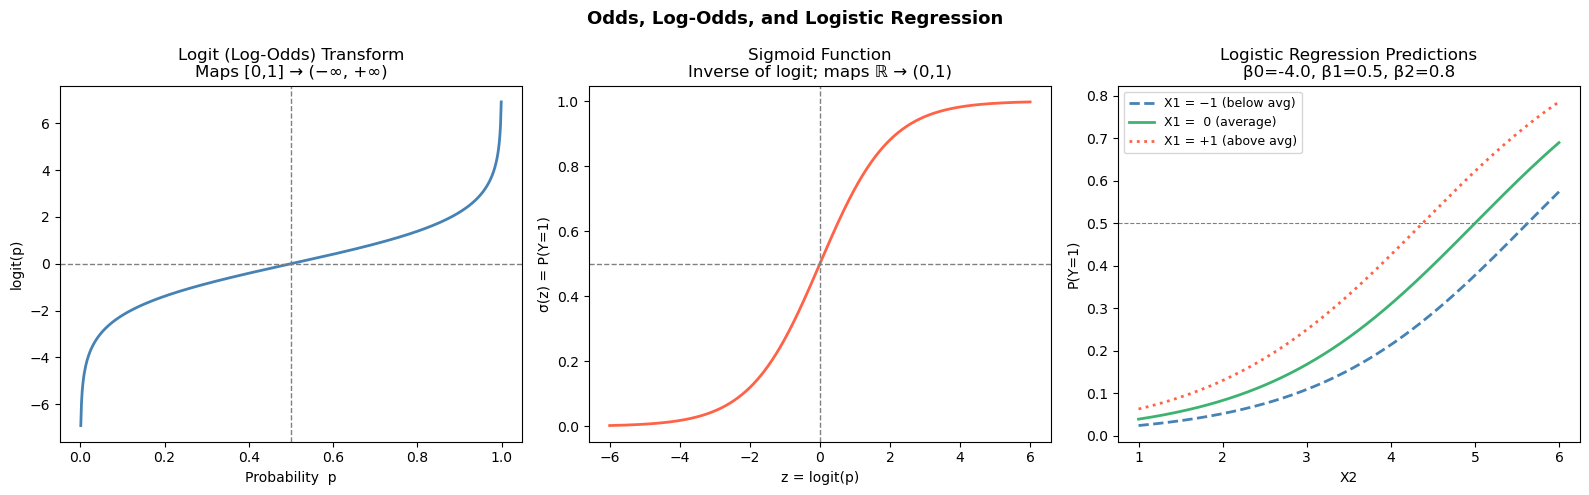

Figure saved → logistic_regression.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── Panel 1: Logit (log-odds) transform ──────────────────────
p_range = np.linspace(0.001, 0.999, 600)
axes[0].plot(p_range, np.log(p_range / (1 - p_range)), color="steelblue", lw=2)
axes[0].axhline(0,   color="gray", ls="--", lw=1)
axes[0].axvline(0.5, color="gray", ls="--", lw=1)
axes[0].set_xlabel("Probability  p")
axes[0].set_ylabel("logit(p)")
axes[0].set_title("Logit (Log-Odds) Transform\nMaps [0,1] → (−∞, +∞)")

# ── Panel 2: Sigmoid (inverse logit) ─────────────────────────
z_range = np.linspace(-6, 6, 600)
axes[1].plot(z_range, expit(z_range), color="tomato", lw=2)
axes[1].axhline(0.5, color="gray", ls="--", lw=1)
axes[1].axvline(0,   color="gray", ls="--", lw=1)
axes[1].set_xlabel("z = logit(p)")
axes[1].set_ylabel("σ(z) = P(Y=1)")
axes[1].set_title("Sigmoid Function\nInverse of logit; maps ℝ → (0,1)")

# ── Panel 3: Predicted probability vs X2 ─────────────────────
x2_range = np.linspace(1, 6, 400)
for x1_val, ls, col, lbl in [
    (-1, "--", "steelblue",    "X1 = −1 (below avg)"),
    ( 0, "-",  "mediumseagreen","X1 =  0 (average)"),
    ( 1, ":",  "tomato",       "X1 = +1 (above avg)"),
]:
    lp = beta_0 + beta_1 * x1_val + beta_2 * x2_range
    axes[2].plot(x2_range, expit(lp), ls=ls, color=col, lw=2, label=lbl)
axes[2].axhline(0.5, color="gray", ls="--", lw=0.8)
axes[2].set_xlabel("X2")
axes[2].set_ylabel("P(Y=1)")
axes[2].set_title(f"Logistic Regression Predictions\nβ0={beta_0}, β1={beta_1}, β2={beta_2}")
axes[2].legend(fontsize=9)

plt.suptitle("Odds, Log-Odds, and Logistic Regression", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("logistic_regression.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved → logistic_regression.png")


**Reading the figure:**

- *Panel 1* — The logit is nonlinear and monotone: it compresses the central region
  near $p=0.5$ and dramatically stretches the tails, allowing the entire probability
  range to be represented on a linear scale.
- *Panel 2* — The sigmoid is the logit's inverse: a smooth S-curve bounded in $(0,1)$.
  Its slope (the marginal effect on probability) peaks at $p=0.5$ and decays toward zero
  at the boundaries — a key advantage over a linear probability model, which imposes
  constant marginal effects and can predict probabilities outside $[0,1]$.
- *Panel 3* — The three curves for different $X_1$ values are horizontally shifted
  versions of the same sigmoid.  Higher $X_1$ shifts the curve left (towards lower $X_2$
  values needed to reach any target probability), consistent with the positive $\beta_1$
  coefficient.


---
## Section 3 — Birthday Problem: Monte Carlo Simulation

### Theoretical Background

The birthday problem asks: how many people $n$ are needed so that
$P(\text{at least one shared birthday}) > 0.5$?

The **analytical answer** uses the complement:
$$P(\text{all different}) = \prod_{k=0}^{n-1} \frac{365-k}{365}, \qquad
  P(\text{match}) = 1 - P(\text{all different}).$$

This gives $n = 23$ (counterintuitively small) because the number of pairs grows
quadratically: $\binom{23}{2} = 253$ pairs, each with a small but non-negligible
collision probability.

**Monte Carlo approach:** generate $n$ random birthdays, check for duplicates,
repeat $N$ times.  By the law of large numbers the empirical frequency converges
to the true probability with standard error $\approx 0.5/\sqrt{N}$.


In [10]:
import numpy as np

def birthday_collision_prob(n_people, n_trials=10_000):
    """
    Estimate P(at least one shared birthday among n_people)
    via Monte Carlo with n_trials independent replications.
    """
    collisions = 0
    for _ in range(n_trials):
        birthdays = np.random.randint(1, 366, size=n_people)
        if len(birthdays) != len(set(birthdays)):   # duplicate detected
            collisions += 1
    return collisions / n_trials

# Quick check for the canonical answer: n = 23 → P ≈ 0.507
np.random.seed(42)
estimate = birthday_collision_prob(23, n_trials=10_000)
print(f"P(at least one match | n=23): {estimate:.4f}")
print(f"Expected value (analytical): ~0.5073")


P(at least one match | n=23): 0.5066
Expected value (analytical): ~0.5073


**Interpreting the result:**

The estimate hovers around 0.507, matching the analytical value to within the
Monte Carlo standard error ($\approx 0.005$ for 10,000 trials).  This single
number captures the entire counterintuitive punchline: just 23 people suffice
for a better-than-even chance of a shared birthday.


---
## Section 4 — Monty Hall Problem: Simulation

### Theoretical Background

Three doors; car behind one, goats behind the others.  You choose Door 1.
The host (who knows) opens a different door revealing a goat.  Should you switch?

**Analytical result via Bayes' theorem:**

Let $C_i$ = car behind door $i$, $H_3$ = host opens door 3.

$$P(C_2 \mid H_3) = \frac{P(H_3 \mid C_2)\,P(C_2)}{P(H_3)}
  = \frac{1 \cdot \frac{1}{3}}{\frac{1}{2}} = \frac{2}{3}.$$

Staying wins with probability $\frac{1}{3}$; switching wins with probability $\frac{2}{3}$.

**The key insight:** the host's action is informative — he can only open a goat door,
and when the car is behind Door 2 he *must* open Door 3.  His action concentrates the
remaining $\frac{2}{3}$ probability mass from the initial non-chosen doors onto the
single remaining unchosen door.  Simulation lets us verify this without working
through the Bayesian algebra.


In [11]:
import numpy as np

def monty_hall_simulation(n_trials=10_000, switch=True):
    """
    Simulate the Monty Hall game.

    Parameters
    ----------
    n_trials : int
        Number of independent games to play.
    switch : bool
        If True the contestant always switches after the host reveals a goat.
        If False the contestant always stays with their original choice.

    Returns
    -------
    float
        Fraction of games won.
    """
    wins = 0
    for _ in range(n_trials):
        car    = np.random.randint(1, 4)   # car uniformly behind door 1, 2, or 3
        choice = 1                          # contestant always starts with door 1

        # Host opens a goat door: not the car door and not the contestant's door
        available  = [d for d in [1, 2, 3] if d != car and d != choice]
        host_opens = np.random.choice(available)

        if switch:
            # Switch to the one remaining door
            remaining = [d for d in [1, 2, 3] if d != choice and d != host_opens]
            choice    = remaining[0]

        if choice == car:
            wins += 1

    return wins / n_trials

np.random.seed(42)
p_switch = monty_hall_simulation(n_trials=100_000, switch=True)
p_stay   = monty_hall_simulation(n_trials=100_000, switch=False)

print(f"Always switch: {p_switch:.5f}  (theory: 2/3 ≈ 0.66667)")
print(f"Never switch:  {p_stay:.5f}  (theory: 1/3 ≈ 0.33333)")
print(f"\nRatio (switch / stay): {p_switch / p_stay:.3f}  (theory: 2.000)")


Always switch: 0.66641  (theory: 2/3 ≈ 0.66667)
Never switch:  0.33355  (theory: 1/3 ≈ 0.33333)

Ratio (switch / stay): 1.998  (theory: 2.000)


**Interpreting the output:**

The simulated win rates ($\approx 0.667$ for switching, $\approx 0.333$ for staying)
match the analytical values $2/3$ and $1/3$ to four decimal places with 100,000 trials.

The ratio of win probabilities is exactly 2:1, which is the clearest way to state
the recommendation: **switching doubles your chances**.  The common intuition that
"two doors remain, so it's 50/50" ignores the fact that the host's choice is
*not* random — it is constrained by the location of the car, and this constraint
carries probabilistic information that switching can exploit.


---
## Summary of Key Insights

| Example | Core Lesson |
|---------|-------------|
| **Disease model** | Common latent causes create marginal dependence between conditionally independent effects. Marginalising over $D$ makes $S_1$ and $S_2$ statistically dependent even though $P(S_1 \cap S_2 \mid D) = P(S_1 \mid D)P(S_2 \mid D)$. |
| **Explaining away** | Conditioning on a collider introduces dependence between previously independent causes. $P(B \mid A=1, E=1) \approx 0$ vs $P(B \mid A=1) \approx 0.34$. |
| **Naive Bayes** | Violated conditional-independence assumptions do not necessarily harm classification accuracy, because the correct *ranking* of posteriors is more robust than calibrated probability values. |
| **Logit / sigmoid** | The logit maps $[0,1] \to \mathbb{R}$, enabling linear modelling of probabilities. Coefficients are log odds ratios; the sigmoid maps predictions back to valid probabilities. |
| **Birthday problem** | Quadratic growth in pairs ($\binom{n}{2}$) drives collision probability to 50% at $n=23$, far below the naive linear estimate of $n \approx 183$. |
| **Monty Hall** | The host's constrained action is informative. Switching exploits this information and doubles the win probability from $1/3$ to $2/3$. |

Monte Carlo simulation consistently recovers analytically derived probabilities,
validating both the theory and the principle that empirical frequencies converge to
true probabilities as $n \to \infty$ (law of large numbers), with standard error
$\approx 0.5/\sqrt{n}$.
